Kvasir V2 dataset trained on all classes with resnet50 without augmentation.  
- Fine tuning by unfreezing some layers (get aprox 90% accuracy)
- Early stopping
- Adaptive learning rate  
`TODO:`  
- DS resample  
- Class weighting  

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'resnet50',
    "DS_INFO": 'complete',
    "resample": False,
    "neg_class": ['polyp'],
    "NUM_EPOCHS": 150,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (32, 32, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

learning_rate = 0.01
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = 10

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['esophagitis' 'normal-pylorus' 'ulcerative-colitis' 'normal-cecum'
 'normal-z-line' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps']

esophagitis       : 1000
normal-pylorus    : 1000
ulcerative-colitis: 1000
normal-cecum      : 1000
normal-z-line     : 1000
polyps            : 1000
dyed-resection-margins: 1000
dyed-lifted-polyps: 1000

Total number of images: 8000, in 8 classes
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[1 2 7 5 7 5 2 0 6 4]
[4 6 2 0 6 0 5 1 1 7]
[2 2 2 3 3 5 0 6 2 2]
[7 4 6 2 4 3 7 2 6 4]
[7 1 5 0 7 2 4 2 4 4]
[5 0 1 5 6 5 5 5 7 7]
[2 0 4 1 0 5 0 7 3 6]
[1 6 5 4 4 2 5 0 7 4]
[7 2 0 6 7 5 6 4 2 7]
[6 4 3 0 4 4 7 3 2 4]

Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200


## Training

### Resnet50 transfer learning
resnet50: https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
fine-tuning: https://www.tensorflow.org/tutorials/images/transfer_learning  
callbacks: https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50  

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras import layers
import datetime

Create and compile the model

In [5]:
res_net = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=config["IMG_SIZE"]
)

In [6]:
res_net.trainable = True

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(params["NUM_CLASSES"], activation='softmax')

resnet50_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [7]:
if config["verbosity"] > 0:
    resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 23,604,104
Trainable params: 23,550,984
Non-trainable params: 53,120
_________________________________________________________________


`Reduce learning rate during training`

In [8]:
# By using LearnignRateScheduler
initial_learning_rate = learning_rate
decay_steps = params["train_size"] // config["BATCH_SIZE"]
batch_size = config['BATCH_SIZE']
decay_rate = 0.6

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)

Compile the model

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] #['sparse_categorical_accuracy']?
)

log_dir="./logs/{}/".format(config["MODEL"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, earlystopp_cb, lr_schedule_cb]

Train the model

In [11]:
history = resnet50_model.fit(
    train_ds,
    steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
    epochs = config["NUM_EPOCHS"],
    validation_data = test_ds,
    validation_steps = params["test_size"] // config["BATCH_SIZE"],
    validation_freq = 1,
    callbacks = callbacks
)

Train for 87 steps, validate for 18 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/150
87/87 [==============================] - 11s 121ms/step - loss: 1.2131 - accuracy: 0.5821 - val_loss: 2.3781 - val_accuracy: 0.1476

Epoch 00002: LearningRateScheduler reducing learning rate to 0.006937799043062201.
Epoch 2/150
87/87 [==============================] - 3s 39ms/step - loss: 0.5687 - accuracy: 0.7773 - val_loss: 2.5032 - val_accuracy: 0.1311

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005311355311355312.
Epoch 3/150
87/87 [==============================] - 3s 39ms/step - loss: 0.3734 - accuracy: 0.8554 - val_loss: 5.8826 - val_accuracy: 0.1111

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0043026706231454005.
Epoch 4/150
87/87 [==============================] - 3s 40ms/step - loss: 0.2587 - accuracy: 0.9080 - val_loss: 6.7502 - val_accuracy: 0.1415

Epoch 00005: LearningRateScheduler reducing learning rate to 0.003

`Keras`
Save/load the model

In [12]:
# resnet50_model.save('models/{}.h5'.format(model_name))
# resnet50_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [13]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

18/18 - 0s - loss: 0.2093 - accuracy: 0.9253


In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(history.epoch[-1]+1)

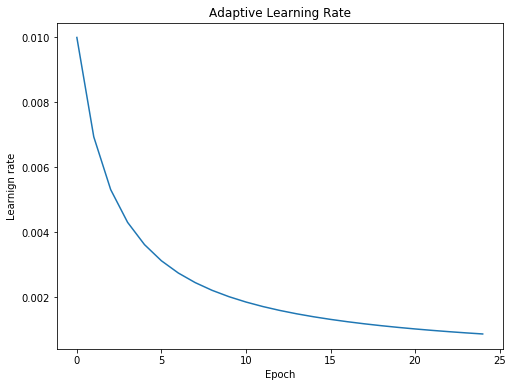

In [15]:
# Plot the learning rate
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, history.history['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learnign rate')
plt.title('Adaptive Learning Rate');

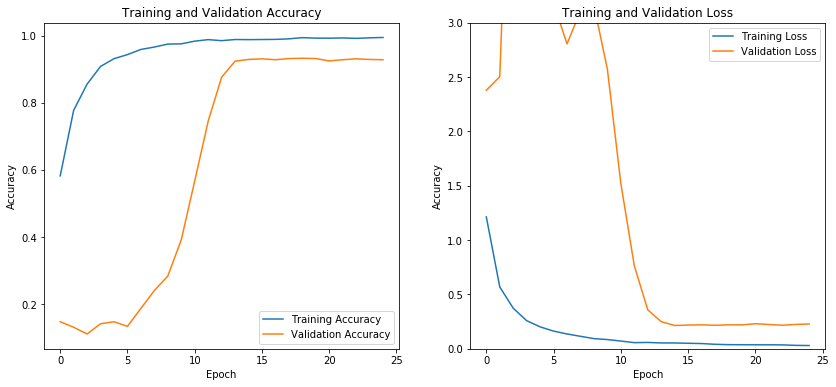

In [16]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

### Fine tune the model

In [ ]:
res_net.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(res_net.layers))

# Fine-tune from this layer onwards
fine_tune_at = fine_tune_at

# Freeze all the layers before the `fine_tune_at` layer
for layer in res_net.layers[:fine_tune_at]:
    layer.trainable = False

print("Number of layers unfreezed: ", len(resnet50_model.trainable_variables))

In [ ]:
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate/10)
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate/10, momentum=0.9)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
fine_tune_epochs = fine_tune_epochs
total_epochs = history.epoch[-1] + fine_tune_epochs

history_fine = resnet50_model.fit(
    train_ds,
    steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
    epochs = total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data = test_ds,
    validation_steps = params["test_size"] // config["BATCH_SIZE"],
    validation_freq = 1,
    callbacks = callbacks
)

In [ ]:
# For fine-tuning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
# Subplot 1
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print ("Fine tuning from epoch: ", history.epoch[-1])

`Tensorboard`

In [17]:
from tensorboard import notebook
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start tensorboard
%tensorboard --logdir logs

notebook.list()

Reusing TensorBoard on port 6007 (pid 22109), started 0:14:26 ago. (Use '!kill 22109' to kill it.)

Known TensorBoard instances:
  - port 6006: logdir logs (started 17:59:20 ago; pid 12596)
  - port 6007: logdir logs (started 0:14:26 ago; pid 22109)


## Predict new samples

In [ ]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

In [ ]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [ ]:
# Predict one batch
predictions = resnet50_model.predict(images)

print ('{:3}  {:<25} {:25}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(25*'-', 25*'-'), end='')

# make a list to store the wrong predictions
wrong_predictions = []

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:25} {:25}'.format(i, label, prediction), end='')
    if (label != prediction): 
        print ("  Wrong", end='')
        wrong_predictions.append(i)

In [ ]:
# Print info about wrong predictions
print("List of wrong predictions from batch:" ,wrong_predictions)
color_string = "\x1b[31m{:0.4f} {}\x1b[0m"

for i, wrong_pred in enumerate(wrong_predictions):
    # Get a random image and label
    rand = wrong_pred
    image = images[rand]
    label = labels[rand]
    
    # Predict one image
    predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]
    pred_label = np.argmax(predictions)
    
    print ("\n\nLabel:", params["class_names"][label])
    print ("Predicton:", params["class_names"][pred_label])
    print ("-------------------------------------")
    for i, pred in enumerate(predictions):
        # print in colors
        if i == pred_label:
            print(color_string.format(pred, params["class_names"][i]))
        else:
            print("{:0.4f} {}".format(pred,params["class_names"][i]))

#     plt.figure(frameon=False, facecolor='white')
#     plt.imshow(image)
#     plt.axis('off');